# INFO 2950 Final Project - Phase IV
##### Janice Shen (js3678), Khai Xin Kuan (kk996), Sandy Lin (sl2534), David Park (yp358)

## Introduction REVISE INTRO AFTER FINDINGS
*State your research question(s) clearly.*

*rubric: All expectations of typical projects + clearly describes why the setting is important and what is at stake in the results of the analysis. Citations to related literature are included that might clarify why the research questions are important, or introduce related research.
Even if the reader doesn’t know much about the subject, they know why they care about the results of your analysis.*

A common interest in both music and finance led the four of us to explore a unique intersection between these fields. Specifically, we asked: could individual music preferences be related to broader economic trends in the United States? Inspired by prior research that suggested promising correlations between music sentiment and market performance (e.g., weekly equity returns) , we decided to investigate further. While excited by the potential connections, our initial data analysis revealed only weak correlations between music sentiment and economic indicators. This prompted us to refine our approaches and think about regression models we could run for the next phase, hoping to reveal hidden trends. 

## Research Questions:
1. **Can the valence of the general population's music preference be predicted by economic indicators such as the unemployment rate, the federal funds rate, and other macroeconomic variables?**
   - *Valence* represents the spectrum of emotions in music, ranging from negative (0) to positive (1).
   - **Goal:** We sought to determine whether broader economic conditions influence the general emotional tone of music that people gravitate toward.

2. **How does danceability correlate with valence, and can we predict the danceability of the general population's music preference based on key economic variables?**
   - *Danceability* measures how suitable a track is for dancing, ranging from 0.0 (least danceable) to 1.0 (most danceable).
   - **Goal:** We explored whether this characteristic, often linked to musical enjoyment, also showed any connections to economic conditions.

### Initial Findings and Methodological Refinement:
Our original analysis included all songs in our dataset and yielded extremely weak correlations. We hypothesized that the inclusion of a large volume of less popular songs may have distorted the results, as these songs might not accurately reflect public sentiment or consumption patterns. To address this, we filtered out less popular songs using a *popularity* metric (a scale from 0 to 100, where 100 indicates the most popular songs). We created a cutoff of 70, focusing on the songs with popularity greater than 70 in our analysis to better capture the music that resonates with the general public.

**Goal:** Even after refining our data, we found weak correlations between music sentiment and the wider US economy. However, in future phases, we aim to obtain more meaningful insights into the relationship between music sentiments and economic variables, with the potential to reveal subtle but significant patterns. 

In [63]:
import pandas as pd
import numpy as np
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Collection and cleaning summary 
**Overall Summary:** The primary task was to match the Billboard song data with Spotify’s sentiment data. This was done by using song titles and artist names as common identifiers. Variations in how song names or artist names were spelled were resolved to make sure the match was accurate. Economic data(eg. Fed fund rate, unemployment rate) was collected through different government sources and merged all economic data into one dataset. Additional control variables were collected to provide context to the economic variables(eg, birth rate, death rate, recession) or other factors influencing music trends.

**Data Standardization:**
- Ensuring consistent formats for song titles and artist names in billboard and spotify dataset
- Ensuring economic variables were comparable across different datasets.
- Handling Missing Data: Missing values were identified and addressed by either excluding records or using imputation methods depending on the context of the missing data and its potential impact on analysis.

**Final Merged Dataset:** 
- After the cleaning and merging steps, a comprehensive, standardized dataset was created that included:
  - Billboard data (song rankings and deta)
  - Spotify sentiment data (emotional tone of songs)
  - Economic data (macroeconomic indicators)
  - Control variables (additional contextual factors).


Final dataset that contains a comprehensive overview of all the music sentiment information, economic information, and additional control variable factors 

In [64]:
final = pd.read_csv('final_clean_data.csv')

inspect the data and see the columns present in the table

In [65]:
final.head() 

,Unnamed: 0,danceability,valence,year,fedfundrate,UnemploymentRate,recession,election,US_GDP,year_1,State_prisons,fertility,DeathRate,S&P500
0,0,0.325,0.9130,1960,3.215833,5.541667,1,1,6.295971,1960,12.153384,3.654,7.199828,0.0
1,1,0.533,0.1905,1960,3.215833,5.541667,1,1,6.295971,1960,12.153384,3.654,7.199828,0.0
2,2,0.498,0.8660,1960,3.215833,5.541667,1,1,6.295971,1960,12.153384,3.654,7.199828,0.0
3,3,0.447,0.3300,1960,3.215833,5.541667,1,1,6.295971,1960,12.153384,3.654,7.199828,0.0
4,4,0.558,0.3030,1960,3.215833,5.541667,1,1,6.295971,1960,12.153384,3.654,7.199828,0.0


Dropping columns not used in our analysis 

In [66]:
print(final.columns) 
final.drop(columns=['year_1','Unnamed: 0'], axis=1, inplace=True)
print(final.columns) 
final.head()

Index(['Unnamed: 0', 'danceability', 'valence', 'year', 'fedfundrate',
       'UnemploymentRate', 'recession', 'election', 'US_GDP', 'year_1',
       'State_prisons', 'fertility', 'DeathRate', 'S&P500'],
      dtype='object')
Index(['danceability', 'valence', 'year', 'fedfundrate', 'UnemploymentRate',
       'recession', 'election', 'US_GDP', 'State_prisons', 'fertility',
       'DeathRate', 'S&P500'],
      dtype='object')


,danceability,valence,year,fedfundrate,UnemploymentRate,recession,election,US_GDP,State_prisons,fertility,DeathRate,S&P500
0,0.325,0.9130,1960,3.215833,5.541667,1,1,6.295971,12.153384,3.654,7.199828,0.0
1,0.533,0.1905,1960,3.215833,5.541667,1,1,6.295971,12.153384,3.654,7.199828,0.0
2,0.498,0.8660,1960,3.215833,5.541667,1,1,6.295971,12.153384,3.654,7.199828,0.0
3,0.447,0.3300,1960,3.215833,5.541667,1,1,6.295971,12.153384,3.654,7.199828,0.0
4,0.558,0.3030,1960,3.215833,5.541667,1,1,6.295971,12.153384,3.654,7.199828,0.0


Creating a DataFrame that aggregates and calculates the average values for each variable by year

In [88]:
averagefinal = duckdb.sql(""" 
                                SELECT
                                    Year,
                                    ANY_VALUE(recession) AS recession,
                                    ANY_VALUE(election) AS election,
                                    AVG(danceability) AS avg_danceability,
                                    AVG(valence) AS avg_valence,
                                    AVG(US_GDP) AS avg_gdp,
                                    AVG(UnemploymentRate) AS avg_unemployment,
                                    AVG(fedfundrate) AS avg_fedfundrate,
                                    AVG(State_prisons) AS avg_imprisonment,
                                    AVG(fertility) AS avg_fertility, 
                                    AVG(DeathRate) AS avg_deathrate, 
                                    AVG("S&P500") AS avg_stockreturn
                                FROM
                                    final
                                GROUP BY
                                    Year
                                ORDER BY
                                    Year
                                """).df()

averagefinal

,year,recession,election,avg_danceability,avg_valence,avg_gdp,avg_unemployment,avg_fedfundrate,avg_imprisonment,avg_fertility,avg_deathrate,avg_stockreturn
0,1960,1,1,0.522367,0.666010,6.295971,5.541667,3.215833,12.153384,3.6540,7.199828,0.00
1,1961,1,0,0.539533,0.714757,6.331875,6.691667,1.955000,12.188178,3.6200,7.169196,0.27
2,1962,0,0,0.562227,0.701820,6.403444,5.566667,2.708333,12.180170,3.4610,7.188111,-0.09
3,1963,0,0,0.545594,0.714175,6.457478,5.641667,3.178333,12.176412,3.3190,7.205115,0.23
4,1964,0,1,0.531146,0.692634,6.528632,5.158333,3.496667,12.168511,3.1900,7.173038,0.16
5,1965,0,0,0.526300,0.652230,6.609740,4.508333,4.075000,12.154016,2.9130,7.175107,0.12
6,1966,0,0,0.564490,0.689643,6.701240,3.791667,5.111667,12.102982,2.7210,7.177019,-0.10
7,1967,0,0,0.549843,0.656637,6.756882,3.841667,4.220000,12.074351,2.5580,7.149917,0.24
8,1968,0,1,0.562324,0.688987,6.846567,3.558333,5.659167,12.029162,2.4640,7.173575,0.11
9,1969,1,0,0.547902,0.653824,6.925217,3.491667,8.204167,12.086799,2.4560,7.148188,-0.08


### Hypothesis 1: 

In [68]:
averagefinal.corr()

,year,recession,election,avg_danceability,avg_valence,avg_gdp,avg_unemployment,avg_fedfundrate,avg_imprisonment,avg_fertility,avg_deathrate,avg_stockreturn
year,1.000000,-0.206685,0.016615,0.814049,-0.888355,0.988029,0.162056,-0.415244,0.963340,-0.586836,-0.988801,-0.011047
recession,-0.206685,1.000000,-0.092683,-0.269806,0.157854,-0.206083,0.146509,0.337344,-0.234529,0.111836,0.173821,-0.180653
election,0.016615,-0.092683,1.000000,0.025618,0.035730,0.007311,-0.047305,-0.080127,0.003395,0.028661,-0.005303,-0.031037
avg_danceability,0.814049,-0.269806,0.025618,1.000000,-0.617255,0.875068,0.174493,-0.016465,0.825846,-0.692282,-0.836224,0.022292
avg_valence,-0.888355,0.157854,0.035730,-0.617255,1.000000,-0.864860,-0.006421,0.466602,-0.872808,0.439940,0.861484,0.037400
avg_gdp,0.988029,-0.206083,0.007311,0.875068,-0.864860,1.000000,0.187272,-0.310200,0.968143,-0.647096,-0.988646,0.016044
avg_unemployment,0.162056,0.146509,-0.047305,0.174493,-0.006421,0.187272,1.000000,0.047247,0.105974,-0.328460,-0.264117,0.246332
avg_fedfundrate,-0.415244,0.337344,-0.080127,-0.016465,0.466602,-0.310200,0.047247,1.000000,-0.429433,-0.257756,0.345897,0.025159
avg_imprisonment,0.963340,-0.234529,0.003395,0.825846,-0.872808,0.968143,0.105974,-0.429433,1.000000,-0.458077,-0.950724,0.023733
avg_fertility,-0.586836,0.111836,0.028661,-0.692282,0.439940,-0.647096,-0.328460,-0.257756,-0.458077,1.000000,0.629138,-0.059219


GDP Coeff: 0.0269
Intercept: 0.5785
MAE for Log(GDP) model: 0.1909
RMSE for Log(GDP) model: 0.0591

Fertility Coeff: 0.0604
Intercept: 0.4810
Death Rate Coeff: 0.2948
Intercept: -1.4194
Death Rate Coeff: 0.0086
Intercept: 0.5656


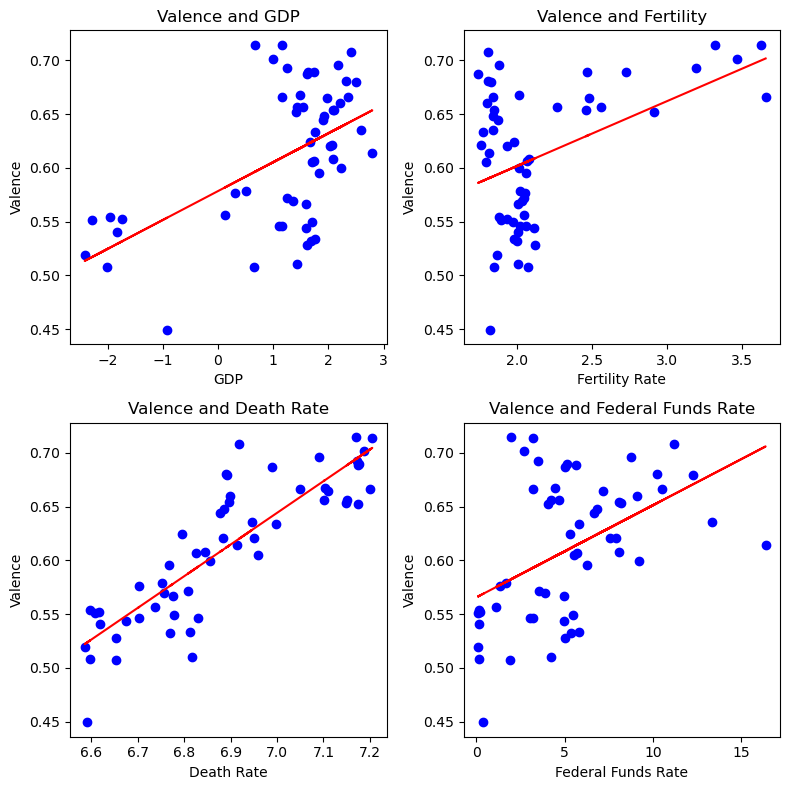

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

#GDP and Valence 
X_gdp = averagefinal[["avg_gdp"]].values
y_gdp = averagefinal["avg_valence"].values
model = LinearRegression().fit(X, y)
print("GDP Coeff:", round(model.coef_[0], 4))
print(f"Intercept: {model.intercept_:.4f}")
y_pred_gdp = model.predict(X_gdp)

mae_gdp = mean_absolute_error(y_gdp, y_pred_gdp)
rmse_gdp = np.sqrt(mean_squared_error(y_gdp, y_pred))
print(f"MAE for Log(GDP) model: {mae_gdp:.4f}")
print(f"RMSE for Log(GDP) model: {rmse_gdp:.4f}\n")

axs[0, 0].scatter(X, y, color="blue")
axs[0, 0].plot(X, model.predict(X), color="red", label="Fitted line")
axs[0, 0].set_title("Valence and GDP")
axs[0, 0].set_xlabel("GDP")
axs[0, 0].set_ylabel("Valence")

#Fertility and Valence 
X = averagefinal[["avg_fertility"]].values
y = averagefinal["avg_valence"].values
model = LinearRegression().fit(X, y)
print("Fertility Coeff:", round(model.coef_[0], 4))
print(f"Intercept: {model.intercept_:.4f}")


axs[0, 1].scatter(X, y, color="blue")
axs[0, 1].plot(X, model.predict(X), color="red", label="Fitted line")
axs[0, 1].set_title("Valence and Fertility")
axs[0, 1].set_xlabel("Fertility Rate")
axs[0, 1].set_ylabel("Valence")

#Death Rate and Valence 
X = averagefinal[["avg_deathrate"]].values
y = averagefinal["avg_valence"].values
model = LinearRegression().fit(X, y)
print("Death Rate Coeff:", round(model.coef_[0], 4))
print(f"Intercept: {model.intercept_:.4f}")

axs[1, 0].scatter(X, y, color="blue")
axs[1, 0].plot(X, model.predict(X), color="red", label="Fitted line")
axs[1, 0].set_title("Valence and Death Rate")
axs[1, 0].set_xlabel("Death Rate")
axs[1, 0].set_ylabel("Valence")

#Federal Funds Rate and Valence 
X = averagefinal[["avg_fedfundrate"]].values
y = averagefinal["avg_valence"].values
model = LinearRegression().fit(X, y)
print("Death Rate Coeff:", round(model.coef_[0], 4))
print(f"Intercept: {model.intercept_:.4f}")

axs[1, 1].scatter(X, y, color="blue")
axs[1, 1].plot(X, model.predict(X), color="red", label="Fitted line")
axs[1, 1].set_title("Valence and Federal Funds Rate")
axs[1, 1].set_xlabel("Federal Funds Rate")
axs[1, 1].set_ylabel("Valence")

plt.tight_layout()

Log(GDP) Coeff: -0.4007
Intercept: 1.4551
Log(Fertility) Coeff: 0.1446
Intercept: 0.5031
Log(Death Rate) Coeff: 2.0378
Intercept: -3.3204
Log(Fed Funds Rate) Coeff: 0.0269
Intercept: 0.5785


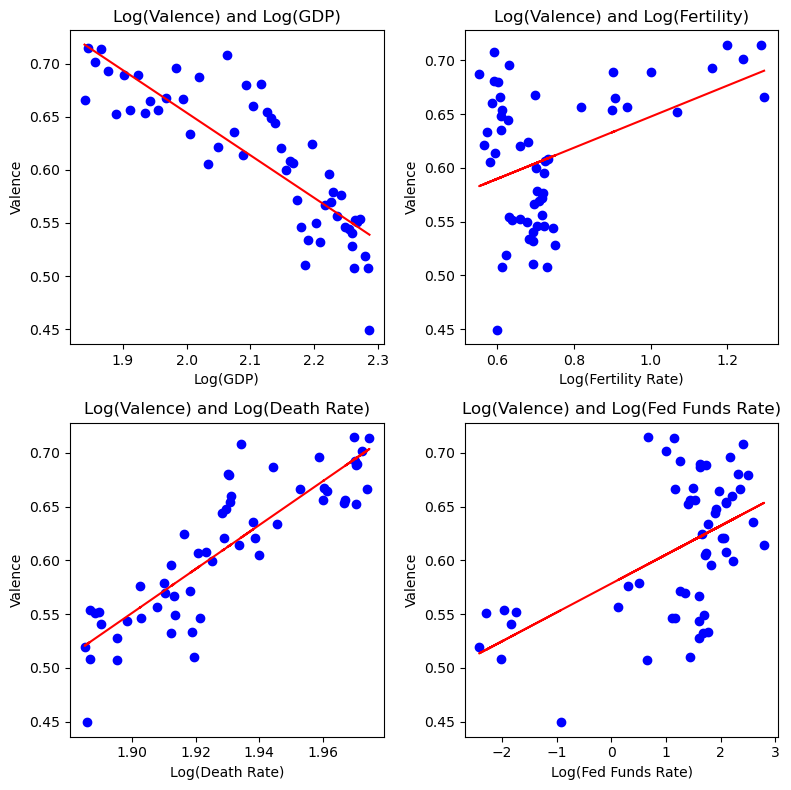

In [91]:

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

#Logged GDP and Valence 
X = np.log(averagefinal[["avg_gdp"]].values) 
y = averagefinal["avg_valence"].values
model = LinearRegression().fit(X_gdp, y_gdp)
print("Log(GDP) Coeff:", round(model.coef_[0], 4))
print(f"Intercept: {model.intercept_:.4f}") 
# y_pred_gdp = model.predict(X_gdp) 

# mae_gdp = mean_absolute_error(y_gdp, y_pred_gdp)
# rmse_gdp = np.sqrt(mean_squared_error(y_gdp, y_pred))
# print(f"MAE for Log(GDP) model: {mae_gdp:.4f}")
# print(f"RMSE for Log(GDP) model: {rmse_gdp:.4f}\n")

axs[0, 0].scatter(X, y, color="blue")
axs[0, 0].plot(X, model.predict(X), color="red", label="Fitted line")
axs[0, 0].set_title("Log(Valence) and Log(GDP)")
axs[0, 0].set_xlabel("Log(GDP)")
axs[0, 0].set_ylabel("Valence")




#Logged Fertility and Valence 
X = np.log(averagefinal[["avg_fertility"]].values)
y = averagefinal["avg_valence"].values
model = LinearRegression().fit(X_fertility, y_fertility)
print("Log(Fertility) Coeff:", round(model.coef_[0], 4))
print(f"Intercept: {model.intercept_:.4f}")
# y_pred_fertility = model.predict(X_fertility) 

# mae_fertility = mean_absolute_error(y_fertility, y_pred_fertility)
# rmse_fertility = np.sqrt(mean_squared_error(y_fertility, y_pred_fertility))
# print(f"MAE for Log(Fertility) model: {mae_fertility:.4f}")
# print(f"RMSE for Log(Fertility) model: {rmse_fertility:.4f}\n")

axs[0, 1].scatter(X, y, color="blue")
axs[0, 1].plot(X, model.predict(X), color="red", label="Fitted line")
axs[0, 1].set_title("Log(Valence) and Log(Fertility)")
axs[0, 1].set_xlabel("Log(Fertility Rate)")
axs[0, 1].set_ylabel("Valence")



#Logged Death Rate and Valence 
X = np.log(averagefinal[["avg_deathrate"]].values) 
y = averagefinal["avg_valence"].values
model = LinearRegression().fit(X_death, y_death)
print("Log(Death Rate) Coeff:", round(model.coef_[0], 4))
print(f"Intercept: {model.intercept_:.4f}")
# y_pred_death = model.predict(X_death)

# mae_death = mean_absolute_error(y_death, y_pred_death)
# rmse_death = np.sqrt(mean_squared_error(y_death, y_pred_death))
# print(f"MAE for Log(Death Rate) model: {mae_death:.4f}")
# print(f"RMSE for Log(Death Rate) model: {rmse_death:.4f}\n")

axs[1, 0].scatter(X, y, color="blue")
axs[1, 0].plot(X, model.predict(X), color="red", label="Fitted line")
axs[1, 0].set_title("Log(Valence) and Log(Death Rate)")
axs[1, 0].set_xlabel("Log(Death Rate)")
axs[1, 0].set_ylabel("Valence")



#Logged Federal Funds Rate and Valeence 
X= np.log(averagefinal[["avg_fedfundrate"]].values)  
y= averagefinal["avg_valence"].values
model = LinearRegression().fit(X_fed, y_fed)
print("Log(Fed Funds Rate) Coeff:", round(model.coef_[0], 4))
print(f"Intercept: {model.intercept_:.4f}")
# y_pred_fed = model.predict(X_fed)

# mae_fed = mean_absolute_error(y_fed, y_pred_fed)
# rmse_fed = np.sqrt(mean_squared_error(y_fed, y_pred_fed))
# print(f"MAE for Log(Fed Fund Rate) model: {mae_fed:.4f}")
# print(f"RMSE for Log(Fed Fund Rate) model: {rmse_fed:.4f}\n")

axs[1, 1].scatter(X, y, color="blue")
axs[1, 1].plot(X, model.predict(X), color="red", label="Fitted line")
axs[1, 1].set_title("Log(Valence) and Log(Fed Funds Rate)")
axs[1, 1].set_xlabel("Log(Fed Funds Rate)")
axs[1, 1].set_ylabel("Valence")

plt.tight_layout()

In [48]:
X = averagefinal[["avg_gdp"]]  
y = averagefinal["avg_valence"] 

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()


print(model.summary())



                            OLS Regression Results                            
Dep. Variable:            avg_valence   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     160.3
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           8.57e-18
Time:                        19:40:52   Log-Likelihood:                 112.19
No. Observations:                  56   AIC:                            -220.4
Df Residuals:                      54   BIC:                            -216.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0326      0.034     30.715      0.0

### Hypothesis 2: 

In [42]:
input_vars = ["avg_unemployment", "election", "avg_deathrate", "avg_stockreturn", "recession"]
X = averagefinal[input_vars]  # The independent variables (features)
y = averagefinal["avg_valence"]  # The dependent variable (target)

# Initialize and fit the linear regression model
model = LinearRegression().fit(X, y)

# Print the coefficients for each variable
for var_name, var_coef in zip(input_vars, model.coef_):
    print(f"{var_name}: {var_coef:.2f}")

# Print the intercept of the model
print(f"Intercept: {model.intercept_:.2f}")

avg_unemployment: 0.01
election: 0.01
avg_deathrate: 0.32
avg_stockreturn: -0.00
recession: -0.01
Intercept: -1.65


In [7]:
X_train= averagefinal[input_vars]
train_predictions = model.predict(X_train)

In [8]:
residuals = averagefinal["avg_valence"] - train_predictions
residuals.head()

0   -0.041125
1    0.013217
2   -0.000414
3    0.006508
4   -0.007063
Name: avg_valence, dtype: float64

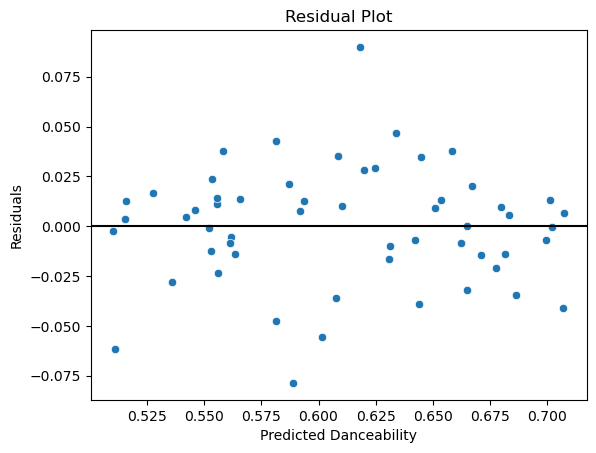

In [17]:
def generate_residual_plot(pred, resid):
    sns.scatterplot(x= pred, y=resid, marker="o")
    plt.axhline(y=0 ,color="black")
    plt.xlabel("Predicted Danceability")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.show()
generate_residual_plot(train_predictions, residuals)

In [18]:
Xmar =  averagefinal[[ "avg_unemployment", "election", "avg_deathrate", \
                      "avg_stockreturn", "recession"]]
ymar = averagefinal[["avg_valence"]]

Xmar = sm.add_constant(Xmar)
est = sm.OLS(ymar, Xmar).fit()
print('Multivar OLS Regression for Valence:')
print(est.summary())

Multivar OLS Regression for Valence:
                            OLS Regression Results                            
Dep. Variable:            avg_valence   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     39.66
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           2.91e-16
Time:                        18:45:39   Log-Likelihood:                 118.47
No. Observations:                  56   AIC:                            -224.9
Df Residuals:                      50   BIC:                            -212.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
con

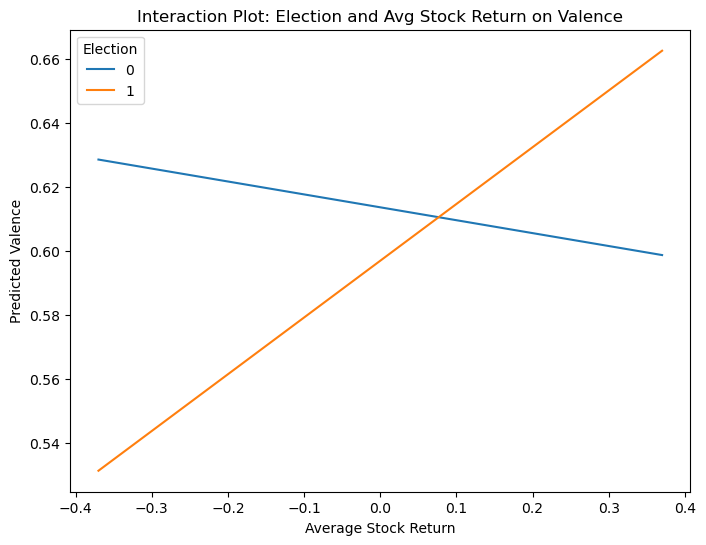

In [13]:
averagefinal['interaction'] = averagefinal['avg_stockreturn'] * averagefinal['election']

# Define independent variables (including interaction) and dependent variable
X = averagefinal[['avg_stockreturn', 'election', 'interaction']]
y = averagefinal['avg_valence']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS regression model
interaction_model = sm.OLS(y, X).fit()

election_levels = [0, 1]
stockreturn_range = np.linspace(averagefinal['avg_stockreturn'].min(), averagefinal['avg_stockreturn'].max(), 100)

plot_data = pd.DataFrame({
    'avg_stockreturn': np.tile(stockreturn_range, len(election_levels)),
    'election': np.repeat(election_levels, len(stockreturn_range))
})
plot_data['interaction'] = plot_data['avg_stockreturn'] * plot_data['election']
plot_data = sm.add_constant(plot_data)

# Predict valence
plot_data['predicted_valence'] = interaction_model.predict(plot_data)

# Plot the interaction effect
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=plot_data,
    x='avg_stockreturn',
    y='predicted_valence',
    hue='election'
)
plt.title("Interaction Plot: Election and Avg Stock Return on Valence")
plt.xlabel("Average Stock Return")
plt.ylabel("Predicted Valence")
plt.legend(title="Election")
plt.show()







*rubric: All expectations of typical projects + credits and values data sources. Thoughtfully addresses whether the datasets are trustworthy and reliable as per Discussion 7.
Includes a comprehensive and clear discussion of different aspects of the data. The reader understands where the data comes from, why it’s useful for the analysis, and any relevant limitations. If needed, another data scientist could easily find the original data using this description and begin to replicate the analysis.
The data cleaning steps are clear and well-commented with markdown text comprehensively explaining the purpose for each step.*

## Data Description

#### What are the observations (rows) and the attributes (columns)?
**Observations**: Each row represents a song or an economic indicator for a specific time period. In the music dataset (musicdata), rows represent individual songs, while in the economic datasets (undata, econdata, us_gdp_data, us_entertainmentgdp_data), rows represent time intervals (e.g., months or quarters).  
**Attributes**: In the **music dataset**, the columns include variables like **valence** (a measure of positivity in music), **danceability**, **popularity**, **year**, and other sentiment-related metrics. For the **economic datasets** columns include **unemployment rate**, **GDP**, **federal funds rate**, and other economic indicators.


#### Why was this dataset created?  
The **music sentiment datasets** were created to explore the relationship between musical attributes (such as valence, danceability, and popularity) and factors like popularity or music trends over time. The **economic datasets** were generated by governmental agencies like the **Federal Reserve** to monitor key economic indicators for research, policy analysis, and public transparency.


#### Who funded the creation of the dataset?
The **music sentiment dataset** were compiled by independent researchers, such as Caleb Elgut, likely with no explicit funding. These data sources rely on platforms like **Spotify**, **Billboard**, and **ARIA**, which collected the original data. The **economic datasets** were funded by the U.S. government through organizations like the **Federal Reserve** and the **Federal Reserve Bank of St. Louis**, as part of their regular efforts to report and track national economic trends.


#### What processes might have influenced what data was observed and recorded and what was not?  
In the **music datasets**, factors like availability on Spotify, scraping techniques, and modern-day popularity metrics may have influenced the data observed. For example, older songs that were popular in the 1990s may have lower popularity today, potentially skewing the results when comparing them to historical economic data. In the **economic datasets**, revisions in how economic indicators like GDP and unemployment are calculated, government adjustments, and data collection methodologies could have impacted the recorded data. Additionally, the time series nature of the data means there may be adjustments due to seasonal variations or changes in reporting practices.


#### What preprocessing was done, and how did the data come to be in the form that you are using?  
- **Music datasets**: The data was scraped from platforms like **Spotify**. Preprocessing included cleaning missing values, and ensuring compatibility between different time periods in the analysis (there was no missing values when we loaded the files).  
- **Economic datasets**: The raw data provided by the **Federal Reserve** was merged and aligned with the music data for time-series analysis. Preprocessing involved cleaning missing values, ensuring consistent date formats, and aligning economic metrics with the appropriate historical periods for comparison with music data.


#### If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?
- **Music datasets**: The data originates from public platforms like **Spotify**, where users are generally aware that their listening habits are tracked. However, artists and listeners would likely be unaware of this specific usage of the data for correlating music preferences with economic trends.  
- **Economic datasets**: Data on economic indicators is collected by government agencies like the **Federal Reserve**, with the understanding that it will be publicly available for research, policy analysis, and economic forecasting.


#### Where can your raw source data be found, if applicable?
1. **Music sentiment datasets**:  
   - Caleb Elgut's dataset scraped from Spotify can be found on GitHub: [Spotify-LSTM Data](https://github.com/calebelgut/spotify-lstm/tree/main/Data)  


2. **Economic datasets**:  
   - Abigail Larion’s dataset on economic indicators (including federal funds rate, real GDP, and unemployment rate) can be found on Kaggle: [Interest Rates Dataset](https://www.kaggle.com/datasets/federalreserve/interest-rates)  
   - Unemployment rate data from Jan 1948 – Sep 2024 is available through the Federal Reserve Economic Data (FRED) platform: [Unemployment Rate](https://fred.stlouisfed.org/series/UNRATE)  
   - Quarterly GDP from Jan 1997 – 2019: [Quarterly GDP](https://fred.stlouisfed.org/series/GDP)  
   - Yearly GDP of the Music/Entertainment Industry from 1997 – 2019: [Entertainment Industry GDP](https://fred.stlouisfed.org/series/USPRFRMSPRTMSMNGSP)

## Preregistration statement
*Provide at least 2 preregistration statements. Each statement contains a hypothesis and a description of analysis to study the hypothesis. It should also include context for why you believe in your hypothesis
by referencing domain knowledge or other literature. Refer to Phase 3 rubric for
more details.*

*rubric: At least 2 statements are detailed. Each statement includes 1 hypothesis and 1 description of the analysis. The preregistered analyses reflect deep and critical thinking about the real-world application from which the data originates. The hypothesis is substantiated by a description of domain knowledge and likely includes some citations. The analyses are described in a way that persuades the reader that their results will be interesting, whether or not they turn out to be
statistically significant.
The analyses referenced are scientifically valid and compelling.*

Hypothesis 1: The average valence of popular songs by year from 1960-2016 in the US has an inverse relationship with the corresponding US Gross Domestic Product (GDP) of the given year.

Analysis: 
We plan to run a linear regression where we input the US GDP (which is the total value of final goods and services of the country and thus indicates an aspect of the US economy) and output the average valence (a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track) of each year’s popular (scraped from Billboard top 100) songs. Therefore, we expect to see β<0. Based on our prior EDA, there is a negative correlation between the US GDP and valence. 


Hypothesis 2: The average danceability of the most popular songs per year from 1960-2016 in the US has an inverse relationship with corresponding US unemployment rate of the given year.

Analysis: 
We will run a linear regression where the input is the average danceability (a measure from 0.0 to 1.0 describing how suitable a track is for dancing based on a combination of musical elements including tempo and rhythm) of each year’s popular songs (scraped from Billboard’s top 100 songs), and output the unemployment rate, which is the percentage of unemployed people actively seeking for jobs. Since we are trying to test the inverse relationship, we expect to see that β < 0. Based on our prior EDA, there is a negative correlation between the US unemployment rate and danceability. 
__________-^notes from phase 3
### First Research Question: Music Valence vs US GDP
**The average valence of popular songs by year from 1960-2016 in the US has an inverse relationship with the corresponding US Gross Domestic Product (GDP) of the given year.** 
- $\beta$ < 0
- $H_0$: The valence of the top 100 Spotify songs per year has no relationship to the US GDP each year.
- $H_A$: The valence of the top 100 Spotify songs per year has an inverse relationship to the US GDP each year.

### Second Research Question: Music Danceability vs US Unemployment
**The average danceability of the most popular songs per year from 1960-2016 in the US has an inverse relationship with corresponding US unemployment rate of the given year.** 
- $\beta$ < 0
- $H_0$: The danceability of the top 100 Spotify songs per year has no relationship to the US unemployment each year.
- $H_A$: The danceability of the top 100 Spotify songs per year has an inverse relationship to the US unemployment each year.

## Data analysis
Carry out the analysis for each preregistration statement.
Interpret analyses appropriately (e.g., regressions should be interpreted using the
summarizing, predicting, and outliers/oddities framework from class).
rubric: All expectations of typical projects + analyses are carefully selected to answer all reasonable questions.
Questions raised by one analysis are addressed in subsequent analyses.
There is not “analysis barf”: i.e., analyses are chosen to clearly answer the research questions. All analyses are interpreted clearly (i.e., there is markdown text describing what is being done, and what the result is, for each analysis).

## Evaluation of significance
Determine statistical significance of observed data.
Interpret findings and conclude whether to reject or fail to reject hypotheses
outlined in preregistration statements.
rubric: Metrics of statistical significance appropriate to the analysis performed are presented. Description of metrics / interpretations of discovered p-values are correct and clear.
Numeric values are interpreted in a way that supports a clear story and leads to a conclusion that creatively ties the analysis together. Overall, presents the results of the analysis through a well-written and cohesive discussion.
Values are presented in context and with clear labels.
No “chart barf”. All figures include an explanation as to why they are shown and interpretations for each figure or table.

## Conclusions
Summarize your answers to your opening research questions.
rubric: Research questions are answered clearly and concisely, using rigorous findings from the previous sections to back up claims.
Substantively engages with the data analysis and the evaluation of significance sections.
Uses key findings from these sections as evidence to support claims in the conclusion.

## Limitations
Outline any potential harms and data gaps and describe how this
could affect conclusions made.
rubric: Creatively identifies potential harms and data gaps, and describes how these could affect the meaning of results, as well as the impact of results on people. Limitations of significance metrics are acknowledged.

## Acknowledgements and Bibliography
Think of this as your Problem 0: what
tools, data, or resources did you use that you should cite? You may format this
section with any citation style.
rubric: Clearly marked and formatted. The group thoughtfully engages with relevant literature on their topic in order to motivate and/or contextualize their findings. All external sources are properly cited in the bibliography and with appropriate in-text citations.